In [120]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 13 16:13:02 2018

@author: 2014_Joon_IBS
"""

import glob

import numpy as np
#np.seterr(divide='ignore', invalid='ignore')  #ignore divide by zero or non
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy
from scipy import ndimage
from skimage.measure import label, regionprops
from sklearn.metrics import classification_report, confusion_matrix
import itertools  # for confusion matrix plot

from PIL import Image as pil_image
import cv2

import tensorflow as tf

from tensorflow.python.framework import ops
from keras import backend as K
from keras.models import model_from_json
from keras.models import load_model

K.set_learning_phase(False)

img_size = 48
# to match the size, dimension, and color channel.
    
def preprocess(img_path):
    img = pil_image.open(img_path)
    img = img.resize((img_size, img_size))
    img_arr = np.asarray(img) / 255.
    img_tensor = np.expand_dims(img_arr, 0)
    img_tensor = np.expand_dims(img_tensor, 3)    
    return img_arr, img_tensor


def grad_cam(model, img_path, class_idx, layer_idx):

    img_arr, img_tensor = preprocess(img_path)

    y_c = model.layers[-1].output.op.inputs[0][0, class_idx]  # final layer (before softmax)

    layer_output = model.layers[layer_idx].output  # pick specific layer output (caution: conv layer only)
    
    grad = K.gradients(y_c, layer_output)[0]  # calculate gradient of y_c w.r.t. A_k from the conv layer output
    gradient_fn = K.function([model.input], [layer_output, grad, model.layers[-1].output])
    
    conv_output, grad_val, predictions = gradient_fn([img_tensor])
    conv_output, grad_val = conv_output[0], grad_val[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)
    
    cam = cv2.resize(cam, (img_size, img_size))
    
    # relu 
    cam = np.maximum(cam, 0)    
    cam = cam / cam.max()
    
    return img_arr, cam, predictions

def generate_bbox(img, cam, thr):
    labeled, nr_objects = ndimage.label(cam > thr)
    props = regionprops(labeled)
    return props

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("normalized")
    else:
        print('without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def make_confusion_matrix(model, x, y, normalize = True):
    predicted = model.predict(x)

    pred_list = []; actual_list =[]
    for i in predicted:
        pred_list.append(np.argmax(i))
    for i in y:
        actual_list.append(np.argmax(i))

    confusion_result = confusion_matrix(actual_list, pred_list)
    plot_confusion_matrix(confusion_result, classes = class_label, normalize = normalize, title = 'Confusion_matrix')
    return confusion_result
    
# ex) confusion_result = make_confusion_matrix(loaded_model, x_test, y_test, False)


In [5]:
import os
os.chdir('/github')

In [6]:
pwd()

'F:\\github'

In [28]:
## 1. load model


## test 2. image sources
testset = glob.glob('testset/face/*')

samples = []
face_classes = ['angry', 'disgust', 'fear', 'happy', 'sad','surprise', 'neutral']

for idx, ci in enumerate(face_classes):
    tmp_dict = {}
    tmp_dict['target'] = ci
    tmp_dict['img_path'] = 'testset/face/' + ci+ '.jpg'
    tmp_dict['class_idx'] = idx
    samples.append(tmp_dict)

In [108]:
jj_path = 'ak_net.json'
hh_path = 'ak_net.h5'

ak_model = load_model(jj_path, hh_path)


In [143]:
pwd

'F:\\python\\grad_cam-master'

In [121]:
def load_model_weight(model_name, weight_name = None):
    
    if weight_name ==None:  # which means, model & weight are saved in one file        
        loaded_model = load_model(model_name)
        print('Model & weight are loaded altogether.')
    else:
        with open(model_name, 'r') as m:
            loaded_model_json = m.read()
        loaded_model = model_from_json(loaded_model_json)   # load model architecture from json
        loaded_model.load_weights(weight_name)        
        print('Model & weight are loaded separately.')
    
    return loaded_model    



Model & weight are loaded altogether.


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:715: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


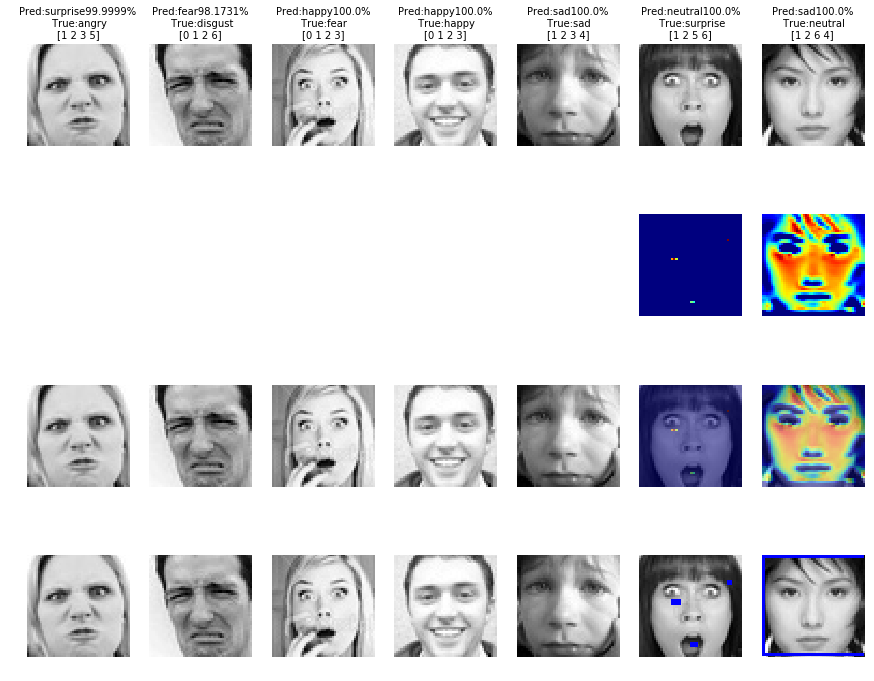

In [142]:

if __name__ == "__main__":
    
    fig, axes = plt.subplots(4, 7, figsize=(15, 12))

    for i, s in enumerate(samples):
        img_set = s['target']
        img_path = s['img_path']
        class_idx = s['class_idx']
        
        img, cam, predictions = grad_cam(ak_net_0, img_path, class_idx, -13)
        
        pred_values = np.squeeze(predictions, 0)
        top1 = np.argmax(pred_values)
        top1_value = np.round(float(pred_values[top1]*100), decimals = 4)
        
        
        
        top4 = np.argpartition(pred_values, -4)[-4:]  #top 4
        
        axes[0, i].imshow(img, cmap='gray')
        axes[1, i].imshow(cam, cmap='jet')
        axes[2, i].imshow(img,cmap='gray')
        axes[2, i].imshow(cam, cmap='jet', alpha=0.5)
        
        props = generate_bbox(img, cam, 0.2)  # image, cam, threshold
        axes[3, i].imshow(img, cmap='gray')
        for b in props:
            bbox = b.bbox
            xs = bbox[1]
            ys = bbox[0]
            w = bbox[3] - bbox[1]
            h = bbox[2] - bbox[0]
    
            rect = patches.Rectangle((xs, ys), w, h, linewidth=3, edgecolor='b', facecolor='none')
            axes[3, i].add_patch(rect)
        
        axes[0,i].axis('off')
        axes[1,i].axis('off')
        axes[2,i].axis('off')
        axes[3,i].axis('off')
        
        axes[0, i].set_title("Pred:{}{}%\n True:{}\n{}".format(face_classes[top1], top1_value, face_classes[class_idx], top4 ), fontsize=10)

    #plt.tight_layout()

    plt.show()

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3)#, figsize=(10, 15))
    

In [10]:
int(3/2)

1

In [125]:
### load from npy 
from keras.utils import np_utils
data_loc = '/tmp/face/'
ak_x_train = np.load(data_loc+'x_train_norm.npy')
ak_y_train = np.load(data_loc+'y_train_norm.npy')

ak_x_test = np.load(data_loc+'x_test_norm.npy')
ak_y_test = np.load(data_loc+'y_test_norm.npy')

ak_y_train = np_utils.to_categorical(ak_y_train, 7)
ak_y_test = np_utils.to_categorical(ak_y_test, 7)

In [128]:
ak_net_0.compile(loss=categorical_crossentropy,optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),metrics=['accuracy'])
ak_scores = ak_net_0.evaluate(ak_x_test, ak_y_test, batch_size=16)      
ak_scores

7178/7178 [==============================] - 64s 9ms/step


[1.3332287258808246, 0.5594873223905279]

In [92]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, TensorBoard

loaded_model.compile(loss=categorical_crossentropy,optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),metrics=['accuracy'])
scores = loaded_model.evaluate(x_test, y_test, batch_size=16)      


7178/7178 [==============================] - 89s 12ms/step


In [96]:
scores

[1.9393010281460237, 0.1485093340763444]

In [97]:
import pandas as pd

### load from csv
file_name = '/python/DDSA/fer/fer2013/fer2013.csv'
def load_data():
    fer = pd.read_csv(file_name)
    fer_train = fer[fer.Usage == 'Training']
    fer_test = fer[fer.Usage.str.contains('Test')]

    x_train = np.array([list(map(int, x.split())) for x in fer_train['pixels'].values])
    y_train = np.array(fer_train['emotion'].values)

    x_test = np.array([list(map(int, x.split())) for x in fer_test['pixels'].values])
    y_test = np.array(fer_test['emotion'].values)

    x_train = normalize_x(x_train)
    x_test = normalize_x(x_test)
    y_train = np_utils.to_categorical(y_train, 7)
    y_test = np_utils.to_categorical(y_test, 7)

    return x_train, x_test, y_train, y_test

def normalize_x(data):
    faces = []

    for face in data:
        face = face.reshape(48, 48) / 255.0
        face = cv2.resize(face, (48, 48))
        faces.append(face)

    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    return faces 

x_train, x_test, y_train, y_test = load_data()